# IAPWS Implementation

In [20]:
import numpy as np
from numpy import exp
from matplotlib import pylab as plt
%matplotlib inline

## The phase boundaries

In [21]:
triple_point   = T_t,p_t = (273.16, 611.657)
critical_point = T_c,p_c = (647.096, 22.064e6)
rho_critical   = rho_c = 322.0

def vapor_pressure(T):
    a = [ None, # Skip to follow IAPWS indexing
        -7.85951783,
         1.84408259,
        -11.7866497,
         22.6807411,
        -15.9618719,
         1.80122502
    ]
    th = 1.0 - T/T_c
    ex = T_c/T * (a[1]*th + a[2]*th**1.5 + a[3]*th**3.0
                  + a[4]*th**3.5 + a[5]*th**4 + a[6]*th**7.5 )
    return p_c * exp(ex)

melting_pressure_range_I = (251.165,273.16)
def melting_pressure_I(T):
    T_n = melting_pressure_range_I[1]
    p_n = 0.000611657e6
    th = T/T_n
    return p_n*(1.0-0.626e6*(1.0-th**-3)+0.197135e6*(1.0-th**21.2))
melting_pressure_range_III = (251.165,256.164)
def melting_pressure_III(T):
    T_n = melting_pressure_range_III[0]
    p_n = 209.9e6
    th = T/T_n
    return p_n*( 1.0-0.295252*(1.0-th**60) )
melting_pressure_range_V = (256.164,273.31)
def melting_pressure_V(T):
    T_n = melting_pressure_range_V[0]
    p_n = 350.1e6
    th = T/T_n
    return p_n*( 1.0 - 1.18721*(1.0-th**8) )

melting_pressure_range_VI = (273.31, 355.0)
def melting_pressure_VI(T):
    T_n = melting_pressure_range_VI[0]
    p_n = 632.4e6
    th = T/T_n
    return p_n * ( 1.0 - 1.07476*(1.0-th**4.6) )
melting_pressure_range_VII = (355.0, 715.0)
def melting_pressure_VII(T):
    T_n = melting_pressure_range_VII[0]
    p_n = 2216.0e6
    th = T/T_n
    return p_n * exp( 1.73683*(1.0-th**-1) - 0.0544606*(1.0-th**5)
                     + 0.806106e-7*(1.0-th**22) )

sublimation_pressure_range = (100, T_t)
def sublimation_pressure(T):
    p_n = 0.000611657e6
    th = T/T_t
    return p_n * exp( -13.928169*(1.0-th**-1.5) + 34.7078238*(1.0-th**-1.25) )

In [61]:
import sympy
T = sympy.Symbol('T')
P_expr = melting_pressure_I(T)
@np.vectorize
def melting_temperature_I(P):
    return float(sympy.nsolve(P_expr-P,T, 0.5*(melting_pressure_range_I[1]-melting_pressure_range_I[0]) ))

Plot the phase diagram:

Text(0,0.5,'Pressure (Pa)')

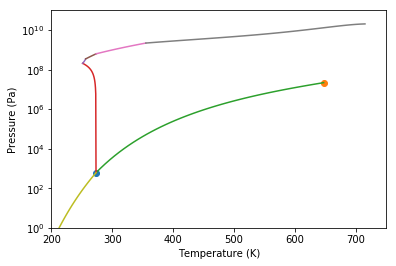

In [62]:
plt.semilogy(triple_point[0],triple_point[1],'o')
plt.semilogy(critical_point[0],critical_point[1],'o')

for f,r in [
    (vapor_pressure,(T_t,T_c)),
    (melting_pressure_I,melting_pressure_range_I),
    (melting_pressure_III,melting_pressure_range_III),
    (melting_pressure_V,melting_pressure_range_V),
    (melting_pressure_VI,melting_pressure_range_VI),
    (melting_pressure_VII,melting_pressure_range_VII),
    (sublimation_pressure,sublimation_pressure_range)
]:
    _ts = np.linspace(r[0],r[1])
    plt.semilogy(_ts,f(_ts),'-')
plt.xlim(200,750)
plt.ylim(1,10.0e10)
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')

To get the quantities we want, density and enthalpy, we need to perform manipulations on the gibbs free energy,
\begin{equation}
\rho = (\partial_p g)^{-1} \\
h = g - T \partial_T g.
\end{equation}
This is easy to do with a computer:

In [63]:
import sympy
def density_enthalpy(gibbs):
    T,p = sympy.symbols('T p')
    g = gibbs(T,p)
    density = 1/g.diff(p)
    enthalpy = g - T * g.diff(T)
    return np.vectorize(sympy.lambdify([T,p], density)), np.vectorize(sympy.lambdify([T,p],enthalpy))

## IAPWS '95

We don't care about computational speed, so maybe it's easier just to implement this?

## IAPWS '97

In [64]:
R = 0.461526e3

### region 1 - Liquid

In [65]:
def gibbs_region1(T,p):
    p1_star = 1.653e7
    T1_star  = 1.386e3
    n1 = [ 0.14632971213167e00, -0.84548187169114e00,
          -3.7563603672040e+00,  3.3855169168385e+00, 
          -0.95791963387872e00,  0.15772038513228e00,
          -1.6616417199501e-02,  8.1214629983568e-04, 
           2.8319080123804e-04, -6.0706301565874e-04,
          -1.8990068218419e-02, -3.2529748770505e-02, 
          -2.1841717175414e-02, -5.2838357969930e-05,
          -4.7184321073267e-04, -3.0001780793026e-04, 
           4.7661393906987e-05,
          
          -4.4141845330846e-06,
          -7.2694996297594e-16, -3.1679644845054e-05, 
          -2.8270797985312e-06, -8.5205128120103e-10,
          -2.2425281908000e-06, -6.5171222895601e-07, 
          -1.4341729937924e-13, -4.0516996860117e-07,
          -1.2734301741641e-09, -1.7424871230634e-10, 
          -6.8762131295531e-19,  1.4478307828521e-20,
           2.6335781662795e-23, -1.1947622640071e-23, 
           1.8228094581404e-24, -9.3537087292458e-26  ]
    i1 = [  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,   
            1,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,    
            8,  8, 21, 23, 29, 30, 31, 32  ]
    j1 = [ -2, -1,   0,   1,   2,   3,   4,   5, -9, -7, -1,  0,  1,    
               3, -3,   0,   1,   3,  17,  -4,   0,  6, -5, -2, 10, -8,   
              -11, -6, -29, -31, -38, -39, -40, -41  ]
    p_i = p/p1_star
    t_i = T1_star/T
    return R*T*sum([ n*(7.1-p_i)**I*(t_i-1.222)**J
            for n,I,J in zip(n1,i1,j1)])
density_region1,enthalpy_region1 = density_enthalpy(gibbs_region1)

### region 2 - Gas

In [66]:
from iapws97 import gibbs_region2, boundary_region23
density_region2,enthalpy_region2 = density_enthalpy(gibbs_region2)

### region 3 - Supercritical

In [67]:
from iapws97 import helmholtz_region3,pressure_enthalpy_from_helmholtz
pressure_region3,enthalpy_region3 = pressure_enthalpy_from_helmholtz(helmholtz_region3)

### region 4 - Liquid - gas interace

In [68]:
from iapws97 import saturation_temperature

## Ice

In [69]:
def gibbs_ice_I(T,p):
    t1 = 3.68017112855051e-2+5.10878114959572e-2j
    t2 = 3.37315741065416e-1+3.35449415919309e-1j
    r1 = 4.47050716285388e1+  6.56876847463481e1j
    r2 = [ -7.25974574329220e01+ -7.81008427112870e1j,
           -5.57107698030123e-5 + 4.64578634580806e5j,
            2.34801409215913e-11+ -2.85651142904972e-11j]
    p_i0 = 1.01325e5 / p_t
    s0 = -3.32733756492168e3
    # s0 = 1.8913e2 for absolute

    G0 = [ -6.32020233335886e5,  6.55022213658955e-1,
           -1.89369929326131e-8,  3.39746123271053e-15,
           -5.56464869058991e-22 ]
    p_i = p/p_t
    T_i = T/T_t
    
    g0_of_p = sum([ gk *(p_i-p_i0)**k for k,gk  in enumerate(G0) ])
    r2_of_p = sum([ r2k*(p_i-p_i0)**k for k,r2k in enumerate(r2) ])
    
    return g0_of_p + s0 * T
density_ice_I,enthalpy_ice_I = density_enthalpy(gibbs_ice_I)

# The complete EOS surface

In [70]:
resolution = 50
P_span_max = 100.0e6

## The phase regimes

In [91]:
# Liquid
data_region1 = []
p_melts = np.geomspace(melting_pressure_I(melting_pressure_range_I[1]),
                       P_span_max,
                       resolution)
t_melts = melting_temperature_I(p_melts)
for tm,pm in zip(t_melts,p_melts):
    t_upper = min(623.15,saturation_temperature(pm))
    tslice = np.linspace(tm,t_upper,resolution)
    pslice = pm*np.ones(resolution)
#     p_upper = vapor_pressure(t_vapor)
    data_region1.append( np.vstack([tslice,pslice,density_region1(tslice,pm),enthalpy_region1(tslice,pm) ]).T )
data_region1 = np.vstack(data_region1)

In [92]:
p_melts

array([6.11657000e+02, 7.81458190e+02, 9.98397636e+02, 1.27556132e+03,
       1.62966800e+03, 2.08207771e+03, 2.66008021e+03, 3.39854112e+03,
       4.34200507e+03, 5.54738263e+03, 7.08738328e+03, 9.05490121e+03,
       1.15686189e+04, 1.47801660e+04, 1.88832658e+04, 2.41254212e+04,
       3.08228435e+04, 3.93795273e+04, 5.03116193e+04, 6.42785531e+04,
       8.21228266e+04, 1.04920822e+05, 1.34047736e+05, 1.71260528e+05,
       2.18803909e+05, 2.79545737e+05, 3.57150013e+05, 4.56297897e+05,
       5.82970078e+05, 7.44807535e+05, 9.51572447e+05, 1.21573706e+06,
       1.55323602e+06, 1.98442756e+06, 2.53532154e+06, 3.23914838e+06,
       4.13836355e+06, 5.28720850e+06, 6.75498259e+06, 8.63022326e+06,
       1.10260467e+07, 1.40869711e+07, 1.79976342e+07, 2.29939307e+07,
       2.93772416e+07, 3.75326140e+07, 4.79519871e+07, 6.12638670e+07,
       7.82712380e+07, 1.00000000e+08])

In [81]:
# gas
data_region2 = []
t_subls = np.linspace(200,T_t,resolution)
p_subls = sublimation_pressure(t_subls)
t_vapor = np.linspace(T_t,T_c,resolution)
p_vapor = vapor_pressure(t_vapor)
t_23 = np.linspace(623.15,900,resolution)
p_23 = boundary_region23(t_23)
for tm,pm in zip(np.r_[t_subls,t_vapor,t_23],
                 np.r_[p_subls,p_vapor,p_23]):
    tslice = np.linspace(tm,1000,resolution)
    pslice = pm*np.ones(resolution)
    data_region2.append( np.vstack([tslice,pslice,density_region2(tslice,pm),enthalpy_region2(tslice,pm), ]).T )
data_region2 = np.vstack(data_region2)

In [82]:
# supercrit
data_region3 = []
ts = np.linspace(623.15,900,resolution)
rho_upper = density_region1(623.15, P_span_max )
for t in ts:
    tslice = t*np.ones(resolution)
    p_bound = boundary_region23(t)
    rho_bound = density_region2(t,p_bound)
    rhoslice = np.linspace(rho_bound,rho_upper,resolution)
    pslice = pressure_region3(tslice,rhoslice)
    hslice = enthalpy_region3(tslice,rhoslice)
    data_region3.append( np.vstack([tslice,pslice,rhoslice,hslice ]).T )
data_region3 = np.vstack(data_region3)

In [83]:
P_span_max

100000000.0

In [84]:
# Ice I
data_ice_I = []
# t_melts = np.linspace(melting_pressure_range_I[0],
#                       melting_pressure_range_I[1],
#                       resolution)
# p_melts = melting_pressure_I(t_melts)
p_melts = np.geomspace(melting_pressure_I(melting_pressure_range_I[0]),
                       melting_pressure_I(melting_pressure_range_I[1]),
                       resolution)
t_melts = melting_temperature_I(p_melts)
t_subls = np.linspace(200,T_t,resolution)
p_subls = sublimation_pressure(t_subls)
for tm,pm in zip(np.r_[t_melts,t_subls],np.r_[p_melts,p_subls]):
    tslice = np.linspace(200,tm,resolution)
    pslice = pm*np.ones(resolution)
#     ps = np.linspace(pstart, pend, resolution)
    data_ice_I.append( np.vstack([tslice,pslice,density_ice_I(tslice,pm),enthalpy_ice_I(tslice,pm) ]).T )
data_ice_I = np.vstack(data_ice_I)

## The equilibria

In [124]:
def equilibria_plane(ts,ps, rho1,h1, rho2,h2):
    data = []
    for tm,pm, rl,hl, rg,hg in zip(ts,ps, rho1,h1, rho2,h2):
        tslice = tm*np.ones(resolution)
        pslice = pm*np.ones(resolution)
        rhoslice = rl + (rg-rl)*np.linspace(0,1,resolution)
        hslice = hl + (hg-hl)*np.linspace(0,1,resolution)
        data.append( np.vstack([tslice,pslice,rhoslice,hslice]).T )
    return np.vstack(data)

In [128]:
# Liquid-gas
t_vapor = np.linspace(T_t,T_c,resolution)
p_vapor = vapor_pressure(t_vapor)
rho_liquid = density_region1(t_vapor,p_vapor)
h_liquid   = enthalpy_region1(t_vapor,p_vapor)
rho_gas    = density_region2(t_vapor,p_vapor)
h_gas      = enthalpy_region2(t_vapor,p_vapor)
data_LG_equi = equilibria_plane(t_vapor,p_vapor,rho_liquid,h_liquid,rho_gas,h_gas)

# Solid-gas
rho_liquid = density_ice_I(t_subls,p_subls)
h_liquid   = enthalpy_ice_I(t_subls,p_subls)
rho_gas    = density_region2(t_subls,p_subls)
h_gas      = enthalpy_region2(t_subls,p_subls)
data_SG_equi = equilibria_plane(t_subls,p_subls,rho_liquid,h_liquid,rho_gas,h_gas)

# Solid-liquid
p_melts = np.geomspace(melting_pressure_I(melting_pressure_range_I[1]),
                       P_span_max,
                       resolution)
t_melts = melting_temperature_I(p_melts)
rho_liquid = density_region1(t_melts,p_melts)
h_liquid   = enthalpy_region1(t_melts,p_melts)
rho_gas    = density_ice_I(t_melts,p_melts)
h_gas      = enthalpy_ice_I(t_melts,p_melts)
data_SL_equi = equilibria_plane(t_melts,p_melts,rho_liquid,h_liquid,rho_gas,h_gas)


In [129]:
import plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# plotly.offline.iplot()

In [130]:
macro = lambda D,c, **kwargs : go.Mesh3d(x=D[:,0],y=np.log(D[:,1]),z=D[:,2],color=c,opacity=0.50,**kwargs)
macro = lambda D,c, **kwargs : go.Scatter3d(x=D[:,0],y=np.log(D[:,1]),z=D[:,2],surfacecolor=c,
                                            mode='markers',marker={'size':2},**kwargs)

data = [
    macro(data_ice_I,'red'),
    macro(data_region1,'blue',),
    macro(data_region2,'yellow'),
    macro(data_region3,'green'),
    
    macro(data_LG_equi,'gray'),
    macro(data_SL_equi,'gray'),
    macro(data_SG_equi,'gray'),

# go.Scatter3d(x=data_region3[:,0],y=np.log(data_region3[:,1]),z=data_region3[:,2]),
    go.Scatter3d(x=[T_t,T_t],y=np.log([p_t,p_t]),z=[0,1000],surfacecolor='black')
]
layout = go.Layout(
    xaxis=dict(
    ),
    yaxis=dict(
        type='log',
        autorange=True
    )
)
fig = go.Figure(data=data,layout=layout)
py.plot(fig)

'file:///Users/afq/Documents/Dropbox/ML/primaryautoencoder/temp-plot.html'